In [3]:
import pickle

import torch
from problems.tsp.problem_tsp import gen_fully_connected_graph, gen_mst_graph, gen_knn_mst_graph, gen_knn_graph
from torch_geometric.data import Data
from tqdm import tqdm

In [ ]:
def rand_gen_mst(idx):
    torch.random.seed()
    g_list = [gen_mst_graph(graph_size) for _ in range(n_samples)]
    torch.save(g_list, save_prefix+f"_{idx}.pkl")
    print(f"dataset-{idx} created")

In [ ]:
import torch.multiprocessing as mp
from torch.multiprocessing import Pool
torch.multiprocessing.set_sharing_strategy('file_system')


In [2]:
n_process = 3
graph_size = 50
n_samples = 128000 // 2
n_repeats = 20
save_prefix = f"/home/pxh/attention-learn-to-route/data/tsp/tsp{graph_size}_train"

In [ ]:
out = []

with Pool(n_process) as p:
    p.map(rand_gen_mst, range(n_repeats))


In [3]:
dataset = []

In [ ]:
for idx in range(n_repeats):
    g_list = torch.load(save_prefix+f"_{idx}.pkl")
    dataset += g_list
len(dataset)

In [7]:
s_len = len(dataset) * 3 // 5
s_len
s_dataset = dataset[:s_len]

In [11]:
with open(save_prefix+f"_pre_generated_small.pkl", 'wb') as f:
    pickle.dump(s_dataset, f)

In [ ]:
with open(save_prefix+f"_pre_generated.pkl", 'wb') as f:
    pickle.dump(dataset, f)

In [4]:
with open(save_prefix+f"_pre_generated.pkl", 'rb') as f:
    dataset = pickle.load(f)

## Generate Graph with networkx

In [49]:
import multiprocessing as mp
from itertools import combinations

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.spatial.distance import cdist
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.transforms.distance import Distance
from networkx.algorithms.tree import mst

In [22]:
%load_ext line_profiler

In [185]:
pos = np.random.uniform(low=0.0, high=1.0, size=(128,10,2))

In [ ]:
dist = cdist(pos, pos, metric='euclidean')

In [ ]:
graph = nx.complete_graph(50)

In [ ]:
for n in graph.nodes:
    graph.nodes[0]["pos"] = pos[n]

In [ ]:
for u, v in graph.edges:
    graph[u][v]["weight"] = dist[u,v]

In [ ]:
mst = nx.algorithms.tree.mst.minimum_spanning_tree(graph, algorithm="prim")

In [11]:
def gen_mst_graph(pos):
#     pos = np.random.uniform(low=0.0, high=1.0, size=(graph_size,2))
    graph_size, _ = pos.shape
    dist = cdist(pos, pos, metric='euclidean')
    graph = nx.complete_graph(graph_size)
    for n in graph.nodes:
        graph.nodes[n]["pos"] = pos[n]
    for u, v in graph.edges:
        graph[u][v]["weight"] = dist[u,v]
        
    mst = nx.algorithms.tree.mst.minimum_spanning_tree(graph, algorithm="prim")
    
    return mst

def gen_complete_graph(pos):
#     pos = np.random.uniform(low=0.0, high=1.0, size=(graph_size,2))
    graph_size, _ = pos.shape
    dist = cdist(pos, pos, metric='euclidean')
    graph = nx.complete_graph(graph_size)
    for n in graph.nodes:
        graph.nodes[n]["pos"] = pos[n]
    for u, v in graph.edges:
        graph[u][v]["weight"] = dist[u,v]
        
    return graph

In [274]:
pos = np.random.uniform(low=0.0, high=1.0, size=(128,50,2))
dist = np.stack([cdist(p, p, metric='euclidean') for p in pos])

In [232]:
g = gen_complete_graph(pos[0])
d=dist[0]
d

array([[0.        , 0.3388081 , 0.79117899, 0.76172133, 0.30008088],
       [0.3388081 , 0.        , 0.7078724 , 0.96401423, 0.59890412],
       [0.79117899, 0.7078724 , 0.        , 0.70008985, 1.07440766],
       [0.76172133, 0.96401423, 0.70008985, 0.        , 0.88294917],
       [0.30008088, 0.59890412, 1.07440766, 0.88294917, 0.        ]])

In [250]:
np.argsort(d)[:, 1:4]

array([4, 1, 3])

In [31]:
def gen_knn(pos, k):
    dist = cdist(pos, pos, metric='euclidean')
    g_size = dist.shape[0]
    k_nn = dist.argsort()[:, 1:k+1]
    node_list = []
    edge_list = []
    for u in range(g_size):
        node_list.append([u, {"pos": pos[u]}])
        for v in k_nn[u]:
            edge_list.append([u,v, {"is_mst": 0.0, "edge_attr": dist[u,v]}])
    g = nx.Graph()
    g.add_nodes_from(node_list)
    g.add_edges_from(edge_list)
    
    return g


In [193]:
def mst_to_knn(graph, k):
    num_edges = graph.num_edges
    graph.is_mst = torch.ones((num_edges, 1), dtype=torch.float)
    pos = graph.pos.numpy()
    dist = cdist(pos, pos, metric='euclidean')
    knn_g = gen_knn(dist, k)
    mst_g = to_networkx(graph, edge_attrs=["is_mst", "edge_attr"], to_undirected=True)
    knn_g.update(mst_g)
    pyg = from_networkx(knn_g)
    
    pyg.pos = graph.pos
    pyg.x = graph.x
    pyg.is_mst = pyg.is_mst.unsqueeze(-1)
    distance.Distance(norm=False, cat=False)(pyg)
    
    return pyg


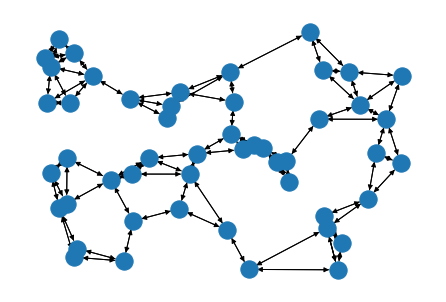

In [23]:
pos = np.random.uniform(low=0.0, high=1.0, size=(50,2))
nx.draw(to_networkx(gen_knn_graph(pos.tolist(), 3)), pos=pos)

In [14]:
pyg = from_networkx(gen_complete_graph(pos))
from torch_geometric.nn import knn_graph
pygknn = knn_graph(pyg.pos, k=3)

In [5]:
from problems.tsp.problem_tsp import gen_knn_mst_graph

In [2]:
val_dataset = "data/tsp/tsp50_validation_seed4321.pkl"

In [3]:
vd = _GNN_TSPDataset(filename=val_dataset, distribution="knn_mst")

Processing...
Done!


In [7]:
import pickle
val_pos = None
with open(val_dataset, "rb") as f:
    val_pos = pickle.load(f)

In [9]:
gen_knn_mst_graph(val_pos[0])

In [4]:
g = gen_knn_mst_graph(10)

In [63]:
from nets import gnn_encoder, gnn_model
from importlib import reload
from utils import torch_load_cpu, load_problem

In [51]:
reload(gnn_encoder)

<module 'nets.gnn_encoder' from '/home/pxh/attention-learn-to-route/nets/gnn_encoder.py'>

In [66]:
problem = load_problem("tsp")
model = gnn_model.GNNFFModel(embedding_dim=128, hidden_dim=128, problem=problem, n_encode_layers=3)
gnn = gnn_encoder.TransformerConv(in_channels=128, out_channels=128//4, heads=4)

In [67]:
data = model._init_embed(g)

In [101]:
x, alpha = gnn(x = data.x, edge_index=data.edge_index, prev_alpha=data.is_mst.expand_as(alpha))

In [102]:
alpha

tensor([[0.2677, 0.2694, 0.2688, 0.2647],
        [0.2602, 0.2598, 0.2596, 0.2630],
        [0.1489, 0.1497, 0.1494, 0.1473],
        ...,
        [0.1294, 0.1276, 0.1310, 0.1258],
        [0.2404, 0.2401, 0.2458, 0.2363],
        [0.0936, 0.0942, 0.0969, 0.0913]],
       grad_fn=<DifferentiableGraphBackward>)

In [14]:
g.is_mst.expand(-1,4)

tensor([[1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0.,

tensor(True)